First we need to pre process audio data and corresponding csv to tensors and we will batch them and feed them into a deep learning model

Building model with reference to Deep Speech 2

we are using jiwer available from pypi by "pip install jiwer" to detect word error rate

In [42]:
#to train with 50-100 epochs
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from jiwer import wer
from IPython import display

<u>Importing the LJSpeech dataset for experiment purpose</u>

<br>ID: this refers to the name of the corresponding wav file
<br>Transcription: word spoken by the user (UTF-8)
<br>Normalized Transcription: transcription with numbers,ordinals and monetary units expanded into full words (UTF-8)

In [43]:
wav_paths=r"F:\Speech Experiment\speechdiarization\Experiment_v2\LJSpeech-1.1\wavs"+"\\"
metadata_path=r'F:\Speech Experiment\speechdiarization\Experiment_v2\LJSpeech-1.1\metadata.csv'

In [44]:
#Read metadata file and parse it
metadata_df=pd.read_csv(metadata_path,sep='|',header=None,quoting=3)

In [45]:
metadata_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [46]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [47]:
metadata_df.columns=['file_name','transcription','normalized_transcription']
metadata_df=metadata_df[['file_name','normalized_transcription']]

metadata_df.head(3)

,file_name,normalized_transcription
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...


In [48]:
metadata_df=metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ032-0231,and other details in the picture.
1,LJ003-0323,"Drunkenness, if it ever occurred, should be vi..."
2,LJ008-0139,"without waiting for any signal, the platform d..."


In [49]:
#train-test split
split=int(len(metadata_df)*0.90)
df_train=metadata_df[:split]
df_val=metadata_df[split:]


print(f'Size of the training set:{len(df_train)}')
print(f'Size of the training set:{len(df_val)}')

Size of the training set:11790
Size of the training set:1310


Preprocessing

In [50]:
#The set of character accepted in transcription
characters=[x for x in "abcdefghijklmnopqrstuvwxyz'?!"]

#Mapping characters to integers
char_to_num=keras.layers.StringLookup(vocabulary=characters,oov_token="")

#Mapping int back to char
num_to_char=keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True)

print(f'The vocabulary is={char_to_num.get_vocabulary()}')
print(f'size={char_to_num.vocabulary_size()}')

The vocabulary is=['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!']
size=30


In [51]:
#An integer scalar Tensor. The window length in samples
frame_length=256
frame_step=160
fft_length=384 #if not provided uses the smallest power of 2 enclosing frame_length

In [52]:
def encode_single_sample(wav_file,label):
    #Reading wav file
    file=tf.io.read_file(wav_paths+wav_file+".wav")
    # print(file)
    #decoding the wav file
    audio,_=tf.audio.decode_wav(file)
    audio=tf.squeeze(audio,axis=-1)#removing the repetative part of the data

    #changing type to float
    audio=tf.cast(audio,tf.float32)

    #Get the Spectrogram
    spectrogram=tf.signal.stft(audio,frame_length=frame_length,frame_step=frame_step,fft_length=fft_length)

    #we only need the magnitude which we can derive by applying tf.abs
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.math.pow(spectrogram,0.5)

    #Normalisation
    means=tf.math.reduce_mean(spectrogram,1,keepdims=True)
    stddevs=tf.math.reduce_std(spectrogram,1,keepdims=True)
    spectrogram=(spectrogram-means)/(stddevs+1e-10)

    #processing the label
    label=tf.strings.lower(label)
    #splitting the label
    label=tf.strings.unicode_split(label,input_encoding="UTF-8")
    #maps the label of characters into numbers
    label=char_to_num(label)

    #returns a dict to the model
    return spectrogram,label


In [53]:
batch_size=32

#Defining the training set
train_dataset=tf.data.Dataset.from_tensor_slices((list(df_train['file_name']),list(df_train['normalized_transcription'])))
train_dataset=(train_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))


#Define the validation set
validation_dataset=tf.data.Dataset.from_tensor_slices((list(df_val['file_name']),list(df_val['normalized_transcription'])))
validation_dataset=(validation_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

F:\Speech Experiment\speechdiarization\Experiment_v2\LJSpeech-1.1\wavs\


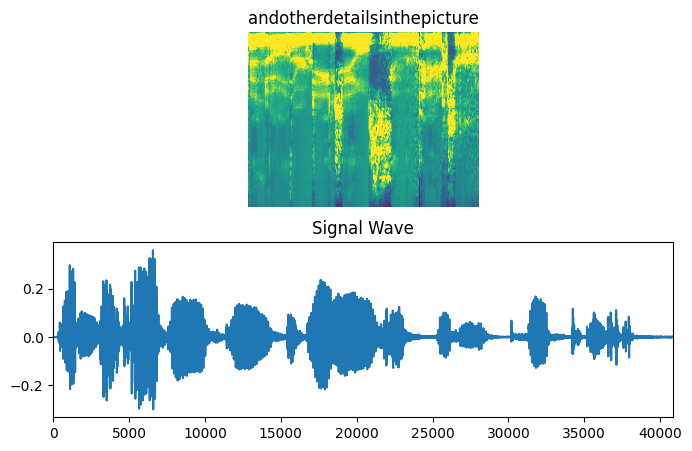

In [55]:
#Visualize the data

fig=plt.figure(figsize=(8,5))

# print(train_dataset.take(1))
for batch in train_dataset.take(1):
    # print(batch)
    spectrogram=batch[0][0].numpy()
    spectrogram=np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label=batch[1][0]

    #spectrogram
    label=tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax=plt.subplot(2,1,1)
    ax.imshow(spectrogram,vmax=1)
    ax.set_title(label)
    ax.axis("off")


    #wav
    print(wav_paths)
    file=tf.io.read_file(wav_paths+list(df_train['file_name'])[0]+".wav")
    audio,_=tf.audio.decode_wav(file)
    audio=audio.numpy()
    ax=plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0,len(audio))
    display.display(display.Audio(np.transpose(audio),rate=16000))

plt.show()

https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c


https://githubharald.github.io/index.html

In [56]:
#Defining the CTC loss function
#connectionist temporist connectionloss
def CTCLoss(y_true,y_pred):
    #compute the training time loss value
    batch_len=tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length=tf.cast(tf.shape(y_true)[1],dtype="int64")

    input_length=input_length*tf.ones(shape=(batch_len,1),dtype="int64")
    label_length=label_length*tf.ones(shape=(batch_len,1),dtype="int64")

    loss=keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)

    return loss

Model :DeepSpeech 2 motivational

In [70]:
def build_model(input_dim,output_dim,rnn_layers=5,rnn_units=128):

    #Model's input
    input_spectrogram=layers.Input((None,input_dim),name="input")

    #Expand the dimension to use 2D-CNN
    x=layers.Reshape((-1,input_dim,1),name="expand_dim")(input_spectrogram)
    #convolution layer-1
    x=layers.Conv2D(filters=32,kernel_size=[11,41],strides=[2,2],padding="same",use_bias=False,name="conv_1",)(x)
    x=layers.BatchNormalization(name="conv_1_bn")(x)
    x=layers.ReLU(name="conv_1_relu")(x)

    #convolution layer -2
    x=layers.Conv2D(filters=32,kernel_size=[11,21],strides=[1,2],padding="same",use_bias=False,name="conv_2",)(x)
    x=layers.BatchNormalization(name="conv_2_bn")(x)
    x=layers.ReLU(name="conv_2_relu")(x)

    #Reshaping the resulted volume to feed to the RNNs Layers
    x=layers.Reshape((-1,x.shape[-2]*x.shape[-1]))(x)
    #RNN Layers
    for i in range(1,rnn_layers+1):
        recurrent=layers.GRU(units=rnn_units,activation="tanh",recurrent_activation="sigmoid",use_bias=True,return_sequences=True,reset_after=True,name=f'gru_{i}',)
        x=layers.Bidirectional(recurrent,name=f"bidirectional_{i}",merge_mode="concat")(x)
        if i<rnn_layers:
            x=layers.Dropout(rate=0.5)(x)
    #Dense Layers
    x=layers.Dense(units=rnn_units*2,name="dense_l")(x)
    x=layers.ReLU(name="dense_1_relu")(x)
    x=layers.Dropout(rate=0.5)(x)

    #classification Layer
    output=layers.Dense(units=output_dim+1,activation="softmax")(x)
    #Model
    model=keras.Model(input_spectrogram,output,name="DeepSpeech2")

    #Optimizer
    opt=keras.optimizers.Adam(learning_rate=1e-4)
    #compiling the model and return the result
    model.compile(optimizer=opt,loss=CTCLoss)
    return model


#Get the Model
model=build_model(input_dim=fft_length//2+1,output_dim=char_to_num.vocabulary_size(),rnn_units=512,)
model.summary(line_length=110)

Model: "DeepSpeech2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                      

In [68]:
def decode_batch_predictions(pred):
    input_len=np.ones(pred.shape[0])*pred.shape[1]
    #using greedy search, for complex task we can use beam search
    results=keras.backend.ctc_decode(pred,input_length=input_len,greedy=True)[0][0]
    #Iterate over the result and get back text
    output_text=[]
    for result in results:
        result=tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

#A callback function to output a few transcription during training
class CallbackEval(keras.callbacks.Callback):
    def __init__(self,dataset):
        super().__init__()
        self.dataset=dataset
    def on_epoch_end(self, epoch:int, logs=None):
        predictions=[]
        targets=[]
        for batch in self.dataset:
            X,y=batch
            batch_predictions=model.predict(X)
            batch_predictions=decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label=(tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                targets.append(label)
        wer_score=wer(targets,predictions)
        print("-"*100)
        print(f'Word Error Rate:{wer_score:.4f}')
        print("-"*100)
        for i in np.random.randint(0,len(predictions),2):
            print(f'Target:{targets[i]}')
            print(f'Predictions:{predictions[i]}')
            print("-"*100)


In [71]:
#define the number of epochs
epochs=2
validation_callback=CallbackEval(validation_dataset)
# model.compile()
#Train the model
history=model.fit(train_dataset,validation_data=validation_dataset,epochs=epochs,callbacks=[validation_callback],)

Epoch 1/2
  2/369 [..............................] - ETA: 14:56:56 - loss: 1520.0073

Inference

In [ ]:
predictions=[]
targets=[]
for batch in validation_dataset:
    X,y=batch
    batch_predictions=model.predict(X)
    batch_predictions=decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label=tf.strings.reduce_join(num_to_char(label).numpy().decode("utf-8"))
        targets.append(label)

wer_score=wer(targets,predictions)
print("-"*100)
print(f'Word Error Rate:{wer_score:.4f}')
print("-"*100)
for i in np.random.randint(0,len(predictions),5):
    print(f'Target:{targets[i]}')
    print(f'Predictions:{predictions[i]}')
    print("-"*100)